In [1]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
import random
import matplotlib.pyplot as plt

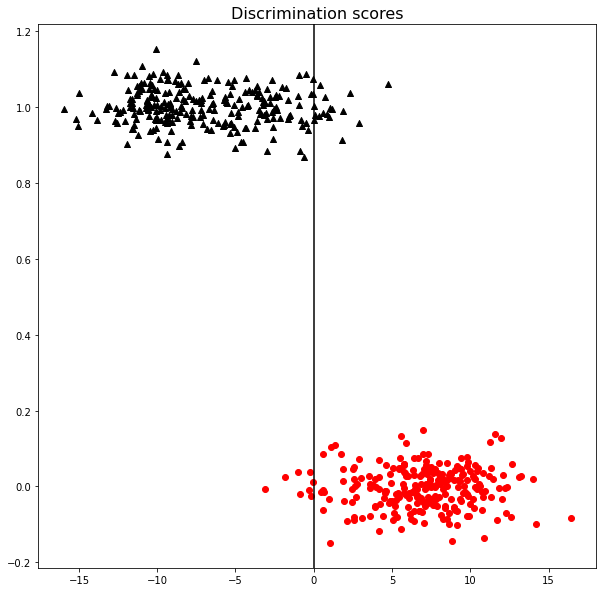

In [2]:
# warning - takes several minutes to run
data = pd.read_csv("bostonh.dat", sep = "\s+", header=None)

# transform data

xt = data
for i in [0, 2, 4, 5, 7, 8, 9, 13]:
    xt.iloc[:, i] = np.log(data.iloc[:, i])
    
xt.iloc[:, 1] = data.iloc[:, 1]/10
xt.iloc[:, 6] = (data.iloc[:, 6]**(2.5))/10000
xt.iloc[:, 10] = np.exp(0.4 * data.iloc[:, 10])/1000
xt.iloc[:, 11] = data.iloc[:, 11]/100
xt.iloc[:, 12] = np.sqrt(data.iloc[:, 12])
data = xt.drop(3, axis = 1)

da = (data - np.mean(data))/np.std(data, ddof = 1)
d = np.zeros([len(da),len(da)])


for i in range(0, len(da)):
    for j in range(0, len(da)):
        d[i, j] = np.linalg.norm(da.iloc[i, :] - da.iloc[j, :])
        
ddd  = d[1:, :-1][:, 0]
for i in range(1, len(da)-1):
    ddd = np.concatenate((ddd, d[1:, :-1][i:, i]))

w = hierarchy.linkage(ddd, 'ward')
tree = hierarchy.cut_tree(w, n_clusters = 2)

da["tree"] = tree

t1 = da[da["tree"] == 0].iloc[:, :-1]
t2 = da[da["tree"] == 1].iloc[:, :-1]

m1 = t1.mean() # mean of first cluster
m2 = t2.mean() # mean of second cluster
m = (m1 + m2)/2 
s = ((len(t1) - 1) * t1.cov() + (len(t2) - 1) * t2.cov())/(len(xt) - 2)
alpha = np.linalg.inv(s) @ (m1 - m2)

mis1  = ((t1 - m) @ alpha < 0).sum()
mis2  = ((t2 - m) @ alpha > 0).sum()

corr1  = ((t1 - m) @ alpha > 0).sum()
corr2  = ((t2 - m) @ alpha < 0).sum()

aper  = (mis1 + mis2)/len(xt)
alph  = (da.iloc[:, :-1] - np.tile(np.array(m), (len(da), 1))) @ alpha

random.seed(1)

p = tree.flatten() + (0.05*np.random.normal(size = len(tree)))

dav = pd.DataFrame(data = {"tree": tree.flatten(), "p": p, "alph": alph})

fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(dav[dav["tree"] == 0]["alph"], dav[dav["tree"] == 0]["p"], c = "r")
ax.scatter(dav[dav["tree"] == 1]["alph"], dav[dav["tree"] == 1]["p"], c = "k", 
           marker = "^")
ax.axvline(0, c = "k")
plt.title("Discrimination scores", fontsize = 16)
plt.show()